# 8-1. 합성곱 연산

In [1]:
import numpy as np
w=np.array([2,1,5,3])
x=np.array([2,8,3,7,1,2,0,4,5])

In [2]:
w_r=np.flip(w)
print(w_r)

[3 5 1 2]


In [3]:
for i in range(6):
    print(np.dot(x[i:i+4],w_r))

63
48
49
28
21
20


In [4]:
from scipy.signal import convolve
convolve(x,w,mode='valid')

array([63, 48, 49, 28, 21, 20])

In [5]:
from scipy.signal import correlate
correlate(x,w,mode='valid')  #valid 패딩

array([48, 57, 24, 25, 16, 39])

In [6]:
correlate(x,w,mode='full')  #full 패딩==zero 패딩

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [7]:
correlate(x,w,mode='same')  #same 패딩

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [8]:
x=np.array([[1,2,3],[4,5,6],[7,8,9]])
w=np.array([[2,0],[0,0]])
from scipy.signal import correlate2d
correlate2d(x,w,mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [9]:
correlate2d(x,w,mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [10]:
import tensorflow as tf
x_4d=x.astype(np.float).reshape(1,3,3,1)
w_4d=w.reshape(2,2,1,1)

In [11]:
c_out=tf.nn.conv2d(x_4d,w_4d,strides=1,padding='SAME')

In [12]:
c_out.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

# 8-2. 풀링 연산

In [13]:
x=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
x=x.reshape(1,4,4,1)

In [16]:
p_out=tf.nn.max_pool2d(x,ksize=2,strides=2,padding='VALID')
p_out.numpy().reshape(2,2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

# 8-3. 합성곱 신경망의 구조

In [17]:
def relu(x):
    return np.maximum(x,0)

In [19]:
x=np.array([-1,2,-3,4,-5])
relu(x)

array([0, 2, 0, 4, 0])

In [20]:
r_out=tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

# 8-4. 합성곱 신경망 만들기

In [22]:
x=tf.Variable(np.array([1.0,2.0,3.0]))
with tf.GradientTape() as tape:
    y=x**3+2*x+5
print(tape.gradient(y,x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [33]:
class ConvolutionNetwork:
    
    def __init__(self,n_kernels=10,units=10,batch_size=32,learning_rate=0.1):
        self.n_kernels=n_kernels
        self.kernel_size=3
        self.optimizer=None     
        self.conv_w=None
        self.conv_b=None
        self.units=units
        self.batch_size=batch_size
        self.w1=None
        self.b1=None
        self.w2=None
        self.b2=None
        self.a1=None
        self.losses=[]
        self.val_losses=[]
        self.lr=learning_rate
        
    def forpass(self,x):
        c_out=tf.nn.conv2d(x,self.conv_w,strides=1,padding='SAME')+self.conv_b
        r_out=tf.nn.relu(c_out)
        p_out=tf.nn.max_pool2d(r_out,ksize=2,strides=2,padding='VALID')
        f_out=tf.reshape(p_out,[x.shape[0],-1])
        z1=tf.matmul(f_out,self.w1)+self.b1
        a1=tf.nn.relu(z1)
        z2=tf.matmul(a1,self.w2)+self.b2
        return z2
    
    def init_weights(self,input_shape,n_classes):             #input_shape 없어도 된다.
        g=tf.initializers.glorot_uniform()
        self.conv_w=tf.Variable(g((3,3,1,self.n_kernels)))
        self.conv_b=tf.Variable(np.zeros(self.n_kernels),dtype=float)
        n_features=14*14*self.n_kernels                      # 28*28인 이미지에만 가능하게 되는디
        self.w1=tf.Variable(g((n_features,self.units)))
        self.b1=tf.Variable(np.zeros(self.units),dtype=float)
        self.w2=tf.Variable(g((self.units,n_classes)))
        self.b2=tf.Variable(np.zeros(n_classes),dtype=float)
        
    def fit(self,x,y,epochs=100,x_val=None,y_val=None):
        self.init_weights(x.shape,y.shape[1])
        self.optimizer=tf.optimizers.SGD(learning_rate=self.lr)
        for i in range(epochs):
            print('에포크',i,end=' ')
            batch_losses=[]
            for x_batch,y_batch in self.gen_batch(x,y):
                print('.',end='')
                self.training(x_batch,y_batch)
                batch_losses.append(self.get_loss(x_batch,y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val,y_val))
            
    def gen_batch(self,x,y):
        bins=len(x)//self.batch_size
        indexes=np.random.permutation(np.arange(len(x)))
        x=x[indexes]
        y=y[indexes]
        for i in range(bins):
            start=self.batch_size*i
            end=self.batch_size*(i+1)
            yield x[start:end],y[start:end]
    def training(self,x,y):
        m=len(x)
        with tf.GradientTape() as tape:
            z=self.forpass(x)
            loss=tf.nn.softmax_cross_entropy_with_logits(y,z)
            loss=tf.reduce_mean(loss)
        weights_list=[self.conv_w,self.conv_b,self.w1,self.b1,self.w2,self.b2]
        grads=tape.gradient(loss,weights_list)
        self.optimizer.apply_gradients(zip(grads,weights_list))
        
    def predict(self,x):
        z=self.forpass(x)
        return np.argmax(z.numpy(),axis=1)
    
    def score(self,x,y):
        return np.mean(self.predict(x)==np.argmax(y,axis=1))
    
    def get_loss(self,x,y):
        z=self.forpass(x)
        loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,z))
        return loss.numpy()

In [34]:
(x_train_all,y_train_all),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [35]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_all,y_train_all,stratify=y_train_all,test_size=0.2,random_state=42)

In [36]:
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)

In [37]:
x_train=x_train.reshape(-1,28,28,1)
x_val=x_val.reshape(-1,28,28,1)

In [38]:
x_train.shape

(48000, 28, 28, 1)

In [39]:
x_train=x_train/255
x_val=x_val/255

In [40]:
cn=ConvolutionNetwork(n_kernels=10,units=100,batch_size=128,learning_rate=0.01)
cn.fit(x_train,y_train_encoded,20,x_val,y_val_encoded)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

In [61]:
a=np.array([1,5,2,6,0,0,3,7,4,8,0,0,0,0,0,0,0,0])     
a1=a.reshape(1,3,3,2)
b=np.array([1,1,1,1,1,1,1,1])
b1=b.reshape(2,2,2,1)
c_out=tf.nn.conv2d(a1,b1,strides=1,padding='SAME')
c_out.numpy().reshape(-1,3,3)

[[[[1 5]
   [2 6]
   [0 0]]

  [[3 7]
   [4 8]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]]]]
[[[[1]
   [2]
   [3]]

  [[4]
   [5]
   [6]]

  [[7]
   [8]
   [9]]]]


array([[[36, 20,  0],
        [22, 12,  0],
        [ 0,  0,  0]]])

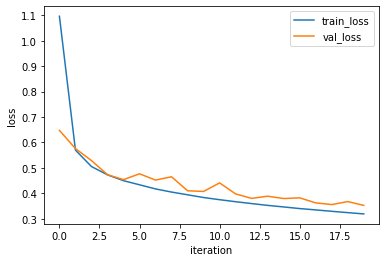

In [49]:
import matplotlib.pyplot as plt
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [50]:
cn.score(x_val,y_val_encoded)

0.88025

# 8-5. 케라스로 합성곱 신경만 만들기

In [62]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

In [63]:
conv1=tf.keras.Sequential()
conv1.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
conv1.add(MaxPooling2D((2,2)))
conv1.add(Flatten())
conv1.add(Dense(100,activation='relu'))
conv1.add(Dense(10,activation='softmax'))

In [64]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [65]:
conv1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=conv1.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5781 - accuracy: 0.8003 - val_loss: 0.3363 - val_accuracy: 0.8792
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3080 - accuracy: 0.8883 - val_loss: 0.2914 - val_accuracy: 0.8947
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2577 - accuracy: 0.9071 - val_loss: 0.2688 - val_accuracy: 0.9056
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2223 - accuracy: 0.9181 - val_loss: 0.2494 - val_accuracy: 0.9127
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2011 - accuracy: 0.9263 - val_loss: 0.2414 - val_accuracy: 0.9159
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1748 - accuracy: 0.9355 - val_loss: 0.2454 - val_accuracy: 0.9143
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1588 - accuracy: 0.9401 - val_loss: 0.2503 - val_accuracy:

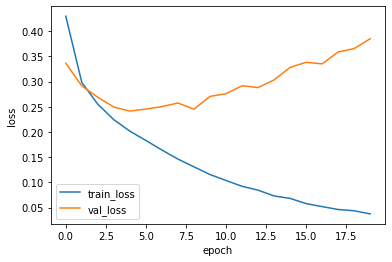

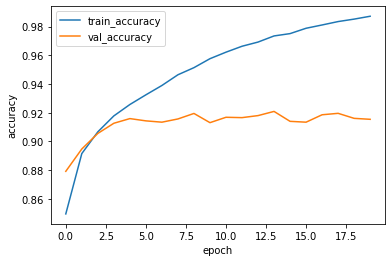

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [68]:
from tensorflow.keras.layers import Dropout

conv2=tf.keras.Sequential()
conv2.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
conv2.add(MaxPooling2D((2,2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100,activation='relu'))
conv2.add(Dense(10,activation='softmax'))

In [69]:
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [72]:
conv2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=conv2.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.7322 - accuracy: 0.7367 - val_loss: 0.3919 - val_accuracy: 0.8577
Epoch 2/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.4118 - accuracy: 0.8501 - val_loss: 0.3231 - val_accuracy: 0.8855
Epoch 3/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3631 - accuracy: 0.8695 - val_loss: 0.2945 - val_accuracy: 0.8932
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3238 - accuracy: 0.8795 - val_loss: 0.2814 - val_accuracy: 0.8964
Epoch 5/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3022 - accuracy: 0.8898 - val_loss: 0.2745 - val_accuracy: 0.8997
Epoch 6/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2882 - accuracy: 0.8932 - val_loss: 0.2566 - val_accuracy: 0.9068
Epoch 7/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2757 - accuracy: 0.8975 - val_loss: 0.2480 - val_accurac

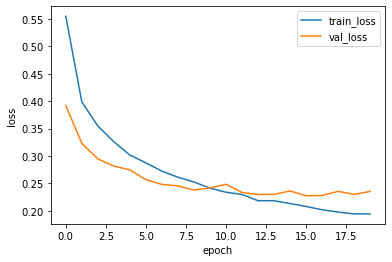

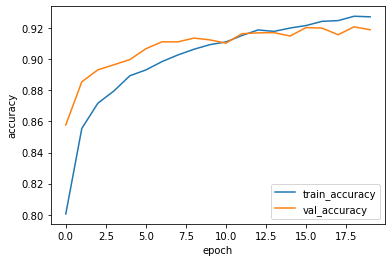

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()